<img src="./01/logo-insa.png" style="float:right; max-width: 60px; display: inline" alt="INSA" /></a>

# Analysis of sizing scenarios at inverter level

*Written by Marc Budinger and Yann Bocquet, INSA Toulouse, France*

We are now going to model the different components of the traction chain (wheel, reducer, motor) in order to assess the voltages and currents to be supplied by the inverter. The voltage / current cycles obtained will subsequently make it possible to evaluate the losses within the converter and to manage the thermal sizing constraints.

### 1. Traction Chain architecture and components

#### 1.1. Global architecture
The traction chain with the motor, the power converter, the battery, the reduction gear and the wheels is now added to the previous vehicle model developped. The cooling system is not modeled at this time and will be developped later.

*Traction chain principle*  
![TractionChain](03/TractionChainPrinciple.png)


#### 1.2. Wheels
The radius of the wheels are chosen equal to 356mm, which corresponds to a 235/65 R16 tyre, which is the standard model for Daily IVECO Van Euro 6 vehicles [(link)](https://www.iveco.com/DailyBusiness/img/doc/BTS_L1612301MASTER_05-16.pdf) (page 26).

In [1]:
Rwheel = 0.356   # [m] Wheel radius

#### 1.3. Battery
The battery is for now modeled as an ideal voltage source. The typical voltage levels of the batteries of this type of vehicles are between 300 and 400V. We will assume for the following a voltage of 300V.

In [2]:
Ubat = 300  # [V] Battery voltage

#### 1.4. Motor

#### 1.4.1. Selected motor
The brushless motor has been selected into the HKW range of Parvex motor ([catalogue](http://parkerstore.lv/pdf/cat4/192_490123_motion-control_products.pdf) see p183). HKW motors are high performance permanent magnet synchronous servomotors for spindle applications up to 230 kW. Delivered as separate components to be integrated into the mechanical structure of the machine, HKW motors benefit from the use of field weakening, in order to achieve both high torque at slow speed, and very high maximum speed at constant power.

*Parvex HKW motor with constant power zone*  
<img src="03/HWK_Motor_TorqueSpeed.png" width="500">

The selected motor is given below:  

*Parvex HKW242_225DAB Datasheet*  
<img src="03/Datasheet1.JPG" width="500">
<img src="03/Datasheet2.JPG" width="500">

This motor is an industrial motor typically used for driving machine tool spindles. It is therefore not an motor specifically developed for the motorization of vehicles. It can however be controlled in defluxing mode in order to present a constant power characteristic well suited to the motorization needs of road vehicles. It only requires a fixed ratio reducer and thus avoids the use of a gearbox with several ratios.

**Remark 1**: Unlike electric vehicle motors, it does not present a strong difference between direct and quadratic inductance (Ld and Lq) in order to  increase torque thanks reluctance effect. The figure below shows a 2010 Prius engine rotor with V-shaped magnets.
For what follows, however, we will limit ourselves to the case Ld = Lq which simplify the modeling.

*V-shaped Interior permanent magnet (IPM) rotor of a 2010 Prius motor ([source](https://www.mdpi.com/2075-1702/8/2/20/htm))*  
<img src="03/VshapePrius.png" width="200">

**Remark 2**: You can find more information about synchronous motor and inverter modeling in the the [Annex A](AA_Traction_Chain_AC.ipynb).

#### 1.4.2. Gear reducer ratio

> **Question:** select a reduction ratio compatible with max speed and max torque of the motor and which maximises power of the motor.
Calculate the motor speeds corresponding to base speeds of 25 or 50 km/h.


In [3]:
import math 

# Calculation of reduction ratio for torque
# -------
MaxForce=12335 # [N] Max traction force
MaxWheelTorque=MaxForce*Rwheel # [N.m] Max global torque 
MaxTorqueMotor=360 #

N_mini=MaxWheelTorque/MaxTorqueMotor # Max torque, if N lower torque is too high

# Calculation of reduction ratio for speed
# -------
MaxSpeed=33.3 # [m/s] Max linear speed
MaxWheelSpeed=MaxSpeed/Rwheel # [rad/s] Max rotational speed

MaxSpeedMotor=13000*2*3.14/60 # [rad/s] Max motor speed

N_maxi=MaxSpeedMotor/MaxWheelSpeed # Max speed, if N higher speed is too high

print("Gear reduction ratio should be between %.2f and %.2f"%(N_mini, N_maxi))

# Calculation of the base speed
# -------

N=N_maxi
print("Gear reduction selected: %.2f"%(N_maxi))
print("---")

# 25 km/h
BaseSpeedLinear25=25/3.6 # [m/s] Base speed for the vehicle
BaseSpeed25=BaseSpeedLinear25/Rwheel*N # [rad/s] base speed for the motor

print("25 km/h of base speed")
print("-")
print("Motor base speed for the application: %.0f rpm or %.2f rad/s"%(BaseSpeed25*60/2/3.14, BaseSpeed25))
print("Motor power: %.2f kW"%(BaseSpeed25*MaxTorqueMotor/1e3))
print("---")

# 50 km/h

BaseSpeedLinear50=50/3.6 # [m/s] Base speed for the vehicle
BaseSpeed50=BaseSpeedLinear50/Rwheel*N # [rad/s] base speed for the motor

print("50 km/h of base speed")
print("-")
print("Motor base speed for the application: %.0f rpm or %.2f rad/s"%(BaseSpeed50*60/2/3.14, BaseSpeed50))
print("Motor power: %.2f kW"%(BaseSpeed50*MaxTorqueMotor/1e3))
print("---")

# 75 km/h

BaseSpeedLinear75=75/3.6 # [m/s] Base speed for the vehicle
BaseSpeed75=BaseSpeedLinear75/Rwheel*N # [rad/s] base speed for the motor

print("75 km/h of base speed")
print("-")
print("Motor base speed for the application: %.0f rpm or %.2f rad/s"%(BaseSpeed75*60/2/3.14, BaseSpeed75))
print("Motor power: %.2f kW"%(BaseSpeed75*MaxTorqueMotor/1e3))
print("---")

Gear reduction ratio should be between 12.20 and 14.55
Gear reduction selected: 14.55
---
25 km/h of base speed
-
Motor base speed for the application: 2711 rpm or 283.76 rad/s
Motor power: 102.15 kW
---
50 km/h of base speed
-
Motor base speed for the application: 5422 rpm or 567.51 rad/s
Motor power: 204.30 kW
---
75 km/h of base speed
-
Motor base speed for the application: 8133 rpm or 851.27 rad/s
Motor power: 306.46 kW
---


#### 1.4.3. Winding adaptation to application

The selected motor doesn't fit with the battery voltage request of 300V with the standard winding (defined for a DC voltage of 540 V). However the winding can be adapted without major performances variation for the motor.

> **Question:** Explain how to adapt winding parameters to a lower voltage motor and a different base speeds. A analysis of effect of turn numbers on back emf constant, winding resistance and inductance can be helpful.


According to Lenz law : $E = - n\frac{d\phi}{dt}$ with $E$ the electromotive force, $n$ the turns number and $\phi = BS$ the magnetic flux. As $\phi$ evolves sinusoidally, we have $E = - nBS\Omega$. As the magnetic field $B$ is produced by permanent magnets it is not impacted by the windings modification and so we have $B^*=1$. As $S$ is related to the size of the motor, that doesn't change in our case, we have $S^*=1$. So we finally have $E^* = n^*\Omega^* \Longleftrightarrow n^* = \frac{E^*}{\Omega^*}$

As $E^* = V^* = U^* = U_{DC}^*$ we have : <span style="color:blue">$n^* = \frac{U_{DC}^*}{\Omega^*}$</span>. So from the imposed battery voltage modification and the base speed modification that we want, we can compute the turns number that we need.   

The windings modification will impact the back emf constant as well as the winding resistance and inductance :
- back emf constant K : 
    - from the previous equation we can deduct that <span style="color:blue">$K^*=n^*$</span>
- winding resistance R : 
    - $R=\frac{\rho L}{S}$ with $\rho$, $L$ and $S$ the resistivity, the length and the section of the wire. As we keep the same type of wire we have $\rho^* = 1$. As the space for the wires is limited, if we add/remove turns, we have to reduce/increase wires section. Thus we have $S^*=\frac{1}{n^*}$. We can also easily find that $L^*=n^*$. Thus we finally have <span style="color:blue">$R^* = {n^*}^2$</span>
- winding inductance L : 
    - We know that for brushless motors $L = \frac{n^2 \mu_0 A_{iron}}{2e}$ with $\mu_0$ the vacuum permeability, $e$ the airgap and $A_{iron}$ the section of the iron bar inside the coil. As we keep the same structure we have $A_{iron}^*=1$ and $e^*=1$. We also have $\mu_0^*=1$. Thus we finally have <span style="color:blue">$L^*=n^{*^2}$</span>

In [4]:
# Calculation of the winding
# ------

# Ref winding parameters
Ke_ref=81.5*math.sqrt(2)/(1000*2*3.14/60)/math.sqrt(3) # [V/(rad/s)] Single phase peak voltage 
Kt_ref=3/2*Ke_ref
Rb_ref=  0.0424 / 2 #[Ω] resistance phase to neutral
Ld_ref= 0.00115 /2  #[H]   transverse inductance (phase-neutral)

pp=4 # Pole pair number

BaseSpeedRef=3710*2*3.14/60 # [rad/s] Reference base speed
Udc_ref=540 # [V] DC voltage reference

# Remark: motor highly saturated for high current which can explain lower inductance and lower DC voltage for high current and high torque

# Adaptation 25 km/h

Udc=300 # [V] Battery DC voltage

Ke25=Ke_ref*Udc/Udc_ref/(BaseSpeed25/BaseSpeedRef) # [V/(rad/s)] Single phase peak voltage 
Kt25=3/2*Ke25 # [N.m/A] torque constant
Rb25=Rb_ref*(Ke25/Ke_ref)**2 # [Ω] resistance phase to neutral
Ld25=Ld_ref*(Ke25/Ke_ref)**2  # [H] transverse inductance (phase-neutral)

print("25 km/h:")
print("Single phase peak voltage Ke = %.2f V/(rad/s)"%Ke25)
print("Torque constant Kt = %.2f [N.m/A]"% Kt25)
print("Resistance phase to neutral Rb = %.2e [Ω]"%Rb25)
print("Transverse inductance (phase to neutral) Ld = %.2e [H]"%Ld25)
print("---")

# Adaptation 50 km/h

Ke50=Ke_ref*Udc/Udc_ref/(BaseSpeed50/BaseSpeedRef) # [V/(rad/s)] Single phase peak voltage 
Kt50=3/2*Ke50 # [N.m/A] torque constant
Rb50=Rb_ref*(Ke50/Ke_ref)**2 # [Ω] resistance phase to neutral
Ld50=Ld_ref*(Ke50/Ke_ref)**2  # [H] transverse inductance (phase-neutral)

print("50 km/h:")
print("Single phase peak voltage Ke = %.2f V/(rad/s)"%Ke50)
print("Torque constant Kt = %.2f [N.m/A]"% Kt50)
print("Resistance phase to neutral Rb = %.2e [Ω]"%Rb50)
print("Transverse inductance (phase to neutral) Ld = %.2e [H]"%Ld50)
print("---")

# Adaptation 75 km/h

Ke75=Ke_ref*Udc/Udc_ref/(BaseSpeed75/BaseSpeedRef) # [V/(rad/s)] Single phase peak voltage 
Kt75=3/2*Ke75 # [N.m/A] torque constant
Rb75=Rb_ref*(Ke75/Ke_ref)**2 # [Ω] resistance phase to neutral
Ld75=Ld_ref*(Ke75/Ke_ref)**2  # [H] transverse inductance (phase-neutral)

print("75 km/h:")
print("Single phase peak voltage Ke = %.2f V/(rad/s)"%Ke75)
print("Torque constant Kt = %.2f [N.m/A]"% Kt75)
print("Resistance phase to neutral Rb = %.2e [Ω]"%Rb75)
print("Transverse inductance (phase to neutral) Ld = %.2e [H]"%Ld75)

25 km/h:
Single phase peak voltage Ke = 0.48 V/(rad/s)
Torque constant Kt = 0.73 [N.m/A]
Resistance phase to neutral Rb = 1.23e-02 [Ω]
Transverse inductance (phase to neutral) Ld = 3.32e-04 [H]
---
50 km/h:
Single phase peak voltage Ke = 0.24 V/(rad/s)
Torque constant Kt = 0.36 [N.m/A]
Resistance phase to neutral Rb = 3.06e-03 [Ω]
Transverse inductance (phase to neutral) Ld = 8.31e-05 [H]
---
75 km/h:
Single phase peak voltage Ke = 0.16 V/(rad/s)
Torque constant Kt = 0.24 [N.m/A]
Resistance phase to neutral Rb = 1.36e-03 [Ω]
Transverse inductance (phase to neutral) Ld = 3.69e-05 [H]


### 2. Traction chain simulation

#### 2.1. Modelica model set-up

>**Question:**  You now have all the characteristic parameters of the vehicle's powertrain. Set up the corresponding Modelica model using the supplied component models. Explain in your report the different control functions performed here.

*Modelica model of the traction chain*  
<img src="03/DriveTrainSimulation.png" width="700">

Remarks: 
- Modelica models are based on the Parvex HKW242_225DAB brushless motor ([catalogue](http://parkerstore.lv/pdf/cat4/192_490123_motion-control_products.pdf)), while the inverter is modeled based on the SKM 400GB123D IGBT module ([datasheet)](https://www.galco.com/techdoc/sekg/skm400gb123d_dat.pdf). Adapt the parameters of the motor to the battery voltage.
- The maximum output voltage of the inverter depends on the PWM used. The simplest PWM allows $U_{max}=\frac{U_{DC}}{2}$, while a slightly more complex one allows $U_{max}=\frac{U_{DC}}{\sqrt{3}}$. We have chosen the 1st one. 



**Answer :** We can observe three main control loops. The loop situated at the right side of the model gives the value of slope as a function of the position. It is the order that situates the horizontal position of the car and associate the corresping slope (made from vertical position) indicated in the Cycle datafile. 
The upper loop controls the speed of the vehicle. The feedback give the error between the command and the real speed. That error is then converted in a torque command who is sended to the motor.
The last loop is a security loop that actuates a mechanical brake when the vehicle goes at a high velocity and the brake demand is high and sudden. It prevents the motor from experiencing high currents. 

#### 2.2. Mission profiles simulation and comparison

>**Questions:**  
> - Configure the components (engine in particular) in order to simulate cycles 1 and 2 with a base speed of 25 or 50 km/h.  
> - Compare the losses of the different cycles. Which cycle do you keep for the rest of the study?
> - Modify the parameters of the inverter to correspond to a component in the Semitrans [range](https://www.semikron.com/products/product-lines/semitrans/semitrans-2-9.html) (select 600V, half-bridge, in production).
> - Calculate the average losses in the diodes and in the IGBTs. Select the base speed and the component which minimize the losses. 


**Answers:**
- Cycle 1 has more losses (mean total loss x2 compare to cycle2): Cycle 1 is selected for sizing and validation purposes.

- With a 300A module ([Datasheet](https://www.semikron.com/dl/service-support/downloads/download/semikron-datasheet-skm300gb066d-21915520.pdf)) for Cycle 1:

In [5]:
import numpy as np
import pandas as pd

ar = np.array([[25, 50,75], [667, 117, 144], [524,449,628], [158,182,270]])
art = np.sum(ar[1:,:], axis=0)
ar = np.append(ar, [art], axis=0)
df = pd.DataFrame(ar, index = ['Base speed (km/h)', 'Motor Loss (W)','6 IGBT loss (W)', '6 Diodes loss (W)', 'Total loss (W)'], columns = ['25 km/h', '50 km/h', '75 km/h'])

df

,25 km/h,50 km/h,75 km/h
Base speed (km/h),25,50,75
Motor Loss (W),667,117,144
6 IGBT loss (W),524,449,628
6 Diodes loss (W),158,182,270
Total loss (W),1349,748,1042


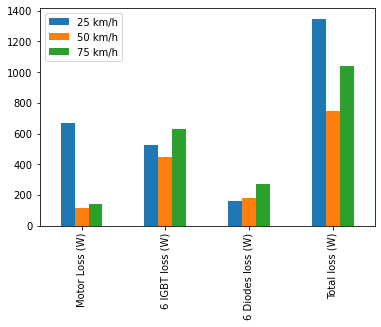

In [6]:
df.iloc[1:,:].plot(kind='bar')

Choosing a base speed of 25 km/h is not a good idea for this cycle. Actually, it is difficult to carry out a simulation that allow to make the regenerative braking function.
The difference of losses in the motor is due to the higher current required for defluxing.

We observe it on the Id (defluxing) and Iq (torque) currents:
![IdIq](./03/IdIq_25vs50kmh.png)

For the rest, we will choose a base speed of 50km / h.

- Then we compare the 300A and 600A modules for a base speed of 50 km/h :

In [7]:
ar = np.array([[50, 50], [300, 600], [117, 117], [449, 402], [182, 176]])
df = pd.DataFrame(ar, index = ['Base speed (km/h)', 'Rated Current (A)','Motor Loss (W)','6 IGBT loss (W)', '6 Diodes loss (W)'], columns = ['300 A', '600 A'])

df

,300 A,600 A
Base speed (km/h),50,50
Rated Current (A),300,600
Motor Loss (W),117,117
6 IGBT loss (W),449,402
6 Diodes loss (W),182,176


The losses are practically similar. The increase of switching losses compensates the decrease of conduction losses. The thermal resistances are however lower for the 600A modules: 0.08 against 0.15 K / W for the IGBTs, 0.125 against 0.25 K / W for the diodes.